In [13]:
import sklearn
import cv2
import os
import pickle
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
!pip install mne
import mne
import pandas as pd
!pip install neupy
import neupy
from sklearn.cluster import KMeans
from neupy import algorithms
import seaborn as sns
from scipy.signal import find_peaks
from mne.utils import logger, verbose

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
with open('/content/drive/MyDrive/s01.dat', 'rb') as file: x = pickle.load(file, encoding='latin1')
data_ = x['data']
eeg_data=data_[:,0:32,:]
print(eeg_data.shape)

(40, 32, 8064)


[3.1462183  4.30571133 3.87961619 ... 3.18765695 4.04046104 4.35953958]


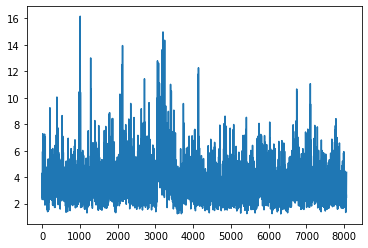

In [16]:
gfp=[]
for video in range(40):
  RMSE_array=[]
  for i in range(len(eeg_data[0][0])):
    v_mean=0
    for j in range(len(eeg_data[0])):
      v_mean=v_mean+eeg_data[video,j,i]
    v_mean=v_mean/len(eeg_data[0])
    squared_error=0
    for j in range(len(eeg_data[0])):
      squared_error=squared_error+(eeg_data[video,j,i]-v_mean)**2
    RMSE=math.sqrt(squared_error/len(eeg_data[0]))
    RMSE_array.append(RMSE)
  #print(len(RMSE_array))
  gfp.append(RMSE_array)
gfp=np.array(gfp)
#print(gfp.shape)
gfp=gfp[0]
gfp=np.transpose(gfp)
print(gfp)
plt.plot([i for i in range(8064)], gfp)

In [17]:
Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,P3,P7,PO3,O1,Oz,Pz,Fp2,AF4,Fz,F4,F8,FC6,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2 = eeg_data[0][:, 1]
col = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
m = [[0, 0, 0, Fp1, 0, Fp2, 0 , 0, 0],
    [0, 0, 0, AF3, 0, AF4, 0, 0, 0],
    [F7, 0, F3, 0, Fz, 0, F4, 0, F8],
    [0, FC5, 0, FC1, 0, FC2, 0, FC6, 0],
    [T7, 0, C3, 0, Cz, 0, C4, 0, T8],
    [0, CP5, 0, CP1, 0, CP2, 0, CP6, 0],
    [P7, 0, P3, 0, Pz, 0, P4, 0, P8],
    [0, 0, 0, PO3, 0, PO4, 0, 0, 0],
    [0, 0, 0, O1, Oz, O2, 0, 0, 0]]

info = np.array([[i, j] for i in range(9) for j in range(9) if m[i][j] != 0])

In [18]:
eeg_data=data_[0,0:32,:]

In [19]:
def locmax(x):
    """Get local maxima of 1D-array
    Args:
        x: numeric sequence
    Returns:
        m: list, 1D-indices of local maxima
    """

    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m

In [20]:
def aahc(data, N_clusters, doplot=False):
    """Atomize and Agglomerative Hierarchical Clustering Algorithm
    AAHC (Murray et al., Brain Topography, 2008)
    Args:
        data: EEG data to cluster, numpy.array (n_samples, n_channels)
        N_clusters: desired number of clusters
        doplot: boolean, plot maps
    Returns:
        maps: n_maps x n_channels (numpy.array)
    """

    def extract_row(A, k):
        v = A[k,:]
        A_ = np.vstack((A[:k,:],A[k+1:,:]))
        return A_, v

    def extract_item(A, k):
        a = A[k]
        A_ = A[:k] + A[k+1:]
        return A_, a

    #print("\n\t--- AAHC ---")
    nt, nch = data.shape

    # --- get GFP peaks ---
    gfp = data.std(axis=1)
    gfp_peaks = locmax(gfp)
    #gfp_peaks = gfp_peaks[:100]
    #n_gfp = gfp_peaks.shape[0]
    gfp2 = np.sum(gfp**2) # normalizing constant in GEV

    # --- initialize clusters ---
    maps = data[gfp_peaks,:]
    # --- store original gfp peaks and indices ---
    cluster_data = data[gfp_peaks,:]
    #n_maps = n_gfp
    n_maps = maps.shape[0]
    print("\t[+] Initial number of clusters: {:d}\n".format(n_maps))

    # --- cluster indices w.r.t. original size, normalized GFP peak data ---
    Ci = [[k] for k in range(n_maps)]
    #print("Ci: ",Ci)

    # --- main loop: atomize + agglomerate ---
    while (n_maps > N_clusters):
       
        # --- correlations of the data sequence with each cluster ---
        m_x, s_x = data.mean(axis=1, keepdims=True), data.std(axis=1)
        m_y, s_y = maps.mean(axis=1, keepdims=True), maps.std(axis=1)
        s_xy = 1.*nch*np.outer(s_x, s_y)
        C = np.dot(data-m_x, np.transpose(maps-m_y)) / s_xy
        #print(C.shape)

        # --- microstate sequence, ignore polarity ---
        L = np.argmax(C**2, axis=1)
        #print(L)

        # --- GEV (global explained variance) of cluster k ---
        gev = np.zeros(n_maps)
        for k in range(n_maps):
            r = L==k
            #print("r:", r)
            gev[k] = np.sum(gfp[r]**2 * C[r,k]**2)/gfp2

        # --- merge cluster with the minimum GEV ---
        imin = np.argmin(gev)
        
        # --- N => N-1 ---
        maps, _ = extract_row(maps, imin)
        Ci, reC = extract_item(Ci, imin)
        #print("Ci : ",Ci)
        #print(reC)
        re_cluster = []  # indices of updated clusters
        #C_sgn = np.zeros(nt)
        for k in reC:  # map index to re-assign
            c = cluster_data[k,:]
            m_x, s_x = maps.mean(axis=1, keepdims=True), maps.std(axis=1)
            m_y, s_y = c.mean(), c.std()
            s_xy = 1.*nch*s_x*s_y
            C = np.dot(maps-m_x, c-m_y)/s_xy
            inew = np.argmax(C**2) # ignore polarity
            #C_sgn[k] = C[inew]
            re_cluster.append(inew)
            Ci[inew].append(k)
        n_maps = len(Ci)

        # --- update clusters ---
        re_cluster = list(set(re_cluster)) # unique list of updated clusters

        
        #print(Ci[inew])
        # re-clustering by eigenvector method
        for i in re_cluster:
            idx = Ci[i]
            Vt = cluster_data[idx,:]
            Sk = np.dot(Vt.T, Vt)
            evals, evecs = np.linalg.eig(Sk)
            c = evecs[:, np.argmax(np.abs(evals))]
            c = np.real(c)
            maps[i] = c/np.sqrt(np.sum(c**2))

    print()
    return maps

	[+] Initial number of clusters: 1943




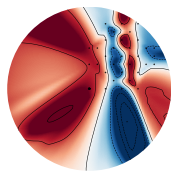

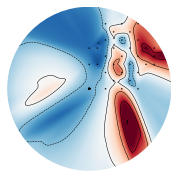

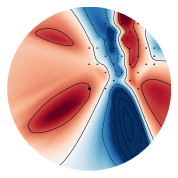

[2 2 2 ... 1 1 1]
For n_outputs 3 GEV is 0.5919359617167606
	[+] Initial number of clusters: 1943



KeyboardInterrupt: ignored

In [21]:
for op in range(3,11):
  maps=aahc(eeg_data.T,op)
  plot_maps(maps,info)
  gfp_sum_sq=np.sum(gfp**2)
  activation=maps.dot(eeg_data)
  seg=np.argmax(np.abs(activation),axis=0)
  print(seg)
  map_corr=_corr_vectors(eeg_data,maps[seg].T)
  gev_aahc=sum((gfp*map_corr)**2)/gfp_sum_sq
  print(f"For n_outputs {op} GEV is {gev_aahc}")